In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
N = 100
L = 1000
T = 20

In [3]:
x = np.empty((N, L), np.float32) #Shape(100,1000)

In [4]:
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1) #1000

In [5]:
y = np.sin(x/1.0/T).astype(np.float32)

In [6]:
plt.figure(figsize=(10,8))

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

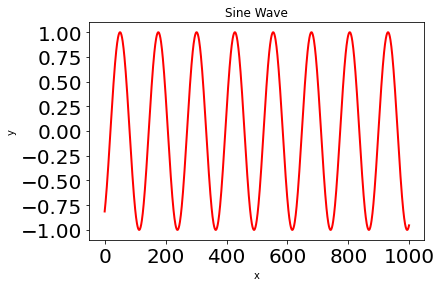

(100, 1000)


In [7]:
plt.title("Sine Wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]), y[0,:], 'r', linewidth=2.0)
plt.show()
print(y.shape)

In [9]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor,self).__init__()
        self.n_hidden = n_hidden
        # lstm1, lstm2, lstm3
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)
    
    def forward(self, x, future=0):
        outputs = []
        n_samples = x.size(0)
        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        
        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        outputs = torch.cat(outputs, dim=1)
        return outputs
            

In [10]:
if __name__ == "__main__":
    # y = 100, 1000
    train_input = torch.from_numpy(y[3:, :-1]) # 97, 999
    train_target = torch.from_numpy(y[3:, 1:]) # 97, 999
    test_input = torch.from_numpy(y[:3, :-1]) #3, 999
    test_target = torch.from_numpy(y[:3, 1:]) #3, 999
    
    model = LSTMPredictor()
    criterion = nn.MSELoss()
    
    optimizer = optim.LBFGS(model.parameters(), lr=0.8)
    
    n_steps = 10
    
    for i in range(n_steps):
        print("Step", i)
        
        def closure():
            optimizer.zero_grad()
            out = model(train_input)
            loss = criterion(out, train_target)
            print("loss", loss.item())
            loss.backward()
            return loss
        
        optimizer.step(closure)
        
        with torch.no_grad():
            future=1000
            pred = model(test_input, future=future)
            loss = criterion(pred[:,:-future], test_target)
            print("test loss", loss.item())
            y = pred.detach().numpy()
        
        plt.figure(figsize=(12,6))
        plt.title("Step %d"%i)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1] # 999
        def draw(y_i, color):
            plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0)
            plt.plot(np.arange(n, n+future), y_i[n:], color + ":", linewidth=2.0)
            
        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        
        plt.savefig("predict%d.pdf"%i)
        plt.close()

Step 0
loss 0.5040186047554016
loss 0.49973753094673157
loss 0.46396806836128235
loss 0.40465545654296875
loss 1.1864811182022095
loss 0.19870874285697937
loss 0.08477499336004257
loss 0.1123322919011116
loss 0.026063507422804832
loss 0.025823531672358513
loss 0.020854076370596886
loss 0.015251985751092434
loss 0.010084953159093857
loss 0.005930113140493631
loss 0.004932372365146875
loss 0.0036235046572983265
loss 0.002968057757243514
loss 0.0017589312046766281
loss 0.0016301627038046718
loss 0.001550967455841601
test loss 0.0012614839943125844
Step 1
loss 0.0013551678275689483
loss 0.001132199540734291
loss 0.0010091571602970362
loss 0.000986092840321362
loss 0.0009758243686519563
loss 0.0009617347968742251
loss 0.0009261266095563769
loss 0.0008569139172323048
loss 0.0007419335888698697
loss 0.0006039604777470231
loss 0.0004900044878013432
loss 0.00042487814789637923
loss 0.00039926759200170636
loss 0.0003884972829837352
loss 0.0003844863676931709
loss 0.0003822492144536227
loss 0.000

In [21]:
print(y)

[[-0.9531152  -1.001962   -0.9956186  ... -0.15934327 -0.20056984
  -0.24129686]
 [-0.5984398  -0.6146257  -0.6489854  ...  0.64824593  0.6175537
   0.58538777]
 [-0.83223736 -0.87671685 -0.89976215 ...  0.35124016  0.31095415
   0.2700112 ]]
